Workflow:
1. Import module and global settings
2. Place for reusable custom functions
3. Reading Boris manual annotation files
4. Reading video files (for travel time)
5. Transformation of data structure for statistics and visualization
6. Statistics
7. Visualization

In [2]:
# Import module and global settings
import cv2
import dabest
import os
import re
import pandas as pd
import tkinter as tk
from tkinter import filedialog


# Set global settings
trials_per_session = 3

# Set up the root window
root = tk.Tk()
root.attributes('-topmost', True)  # 將主視窗設置為最上層
root.withdraw()  # 隱藏主視窗


''

In [3]:
# Place for reusable custom functions


# select_files
def select_files_get_paths(prompt):
    """
    Prompt the user to select multiple files using a GUI.

    Parameters:
    prompt (str): The prompt message to display in the file dialog.

    Returns:
    tuple: A tuple containing the paths of the selected files.
    """
    # create an tuple to store the file paths
    file_paths = []

    while True:

        files = filedialog.askopenfilenames(parent=root, title=prompt)
        
        if not files:
            break
        file_paths.extend(files)

    return file_paths

# Detect the start of valid data in the BORIS file
def detect_valid_data_start(file_path):

    """
    Detect the start of valid data in the BORIS file.

    Parameters:
    file_path (str): The path to the file to read.

    Returns:
    int or None: The line number where valid data starts, or None if not found.
    """
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        for idx, line in enumerate(lines):
            if 'Time' in line and 'Behavior' in line:
                return idx
        print(f"No valid header found in file: {file_path}")
        return None
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

# Extract the experiment information from the file path
def extract_experiment_info(file_path, file_type):
    """
    Extract experiment condition, trial type, mouse ID, and trial number from the file path.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    tuple: A tuple containing the experiment condition, trial type, mouse ID, and trial number.
    """
    # 使用正則表達式匹配實驗條件、trial type、小鼠 ID 和試驗編號
    if file_type == 'video':
        match = re.search(r".*?/8f_behav/balance_beam/\d{4}[A-Za-z]+/(?P<session>[^/]+)/Footage/MP4/(?P<genotype>[^/]+)/(?P<trial_type>\d+mm)_(?P<mouse_id>[A-Za-z0-9]+)-(?P<trial_number>\d+)\.MP4"
, file_path)
        
        if match:
            session = match.group('session')
            genotype = match.group('genotype')
            trial_type = match.group('trial_type')
            mouse_id = match.group('mouse_id')
            trial_number = int(match.group('trial_number'))
            return session, genotype, trial_type, mouse_id, trial_number
        
        else:
            print(f"No valid experiment info found in file path: {file_path}")
            return None, None, None, None, None

    if file_type == 'boris':
        match = re.search(r'/boris_output/(?P<genotype>[^/]+)/(?P<mouse_id>\d+[A-Z])_(?P<session>[^_]+)_(?P<trial_type>\d+mm)\.csv', file_path)
        if match:
            genotype = match.group('genotype')
            mouse_id = match.group('mouse_id')
            session = match.group('session')
            trial_type = match.group('trial_type')
            return session, genotype, trial_type, mouse_id
    
        else:
            print(f"No valid experiment info found in file path: {file_path}")
            return None, None, None, None

# Load BORIS data
def load_boris_data(file_paths):
    """
    Load and preprocess BORIS behavior data from multiple files.

    Parameters:
    file_paths (tuple): A tuple containing the paths of the selected files.

    Returns:
    dict: A dictionary where keys are (session, genotype, trial_type, mouse_id, trial_number) and values are float representing the number of behaviors.
    """
    all_data = {}

    for file_path in file_paths:
        start_line = detect_valid_data_start(file_path)
        if start_line is None:
            print(f"Skipping file {file_path} due to missing valid header.")
            continue
        try:
            boris_data = pd.read_csv(file_path, skiprows=start_line)
            # 確認可能的行為欄位名稱
            behavior_columns = [col for col in boris_data.columns if 'Behavior' in col or 'Event' in col]
            if not behavior_columns:
                print(f"No behavior-related column found in file: {file_path}")
                continue
            # 使用第一個找到的行為欄位
            behavior_column = behavior_columns[0]

            if len(boris_data[behavior_column].value_counts()) == 0:
                behavior_counts = 0
            else:
                behavior_counts = boris_data[behavior_column].value_counts()[0] / trials_per_session
            


            session, genotype, trial_type, mouse_id = extract_experiment_info(file_path, 'boris')
            if session and genotype and trial_type and mouse_id:
                key = (session, genotype, trial_type, mouse_id)
                if key not in all_data:
                    all_data[key] = []
                all_data[key].append(behavior_counts)
                
        except Exception as e:
            print(f"Error loading BORIS file {file_path}: {e}")
            continue

    return all_data

def calculate_intersession_delta(data, session2, session1):
    """
    Calculate the difference in behavior measurements between sessions.

    Parameters:
    data (dict): A dictionary where keys are (session, genotype, trial_type, mouse_id) and values are lists of behavior measurements.
    session1 (str): The first session to compare (e.g., "saline").
    session2 (str): The second session to compare (e.g., "CTZ").

    Returns:
    dict: A dictionary where keys are (intersession, genotype, trial_type, mouse_id)
          and values are lists containing the differences in behavior counts (session2 - session1).
    """
    # Initialize dictionary to store intersession deltas
    intersession_deltas = {}

    # Temporary storage for session data
    session_data = {}

    # Iterate through the data to organize by genotype, trial_type, and mouse_id
    for (session, genotype, trial_type, mouse_id), measurements in data.items():
        # Calculate the average for the session
        avg_measurement = sum(measurements) / len(measurements) if measurements else 0

        key = (genotype, trial_type, mouse_id)

        # Add the session's average to the temporary storage
        if key not in session_data:
            session_data[key] = {}
        session_data[key][session] = avg_measurement

    # Calculate deltas for pairs of sessions
    for key, sessions in session_data.items():
        genotype, trial_type, mouse_id = key
        if session2 in sessions and session1 in sessions:
            delta = sessions[session2] - sessions[session1]
            intersession_key = (f"{session2}-{session1}", genotype, trial_type, mouse_id)

            if intersession_key not in intersession_deltas:
                intersession_deltas[intersession_key] = []
            intersession_deltas[intersession_key].append(delta)  # Ensure the value is a list

    return intersession_deltas

def calculate_video_durations(file_paths):
    """
    Calculate the duration of each video file and handle cases where keys can repeat.

    Parameters:
    file_paths (tuple): A tuple containing the paths of the selected files.

    Returns:
    dict: A dictionary where keys are (session, genotype, trial_type, mouse_id)
          and values are lists of durations for all matching videos in seconds.
    """
    durations = {}

    for file_path in file_paths:
        # 確認檔案是否存在且可讀取
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        try:
            # 讀取影片檔案
            video = cv2.VideoCapture(file_path)
            if not video.isOpened():
                print(f"Unable to open video file: {file_path}")
                continue

            # 計算影片時長
            fps = video.get(cv2.CAP_PROP_FPS)  # 每秒幀數
            frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)  # 總幀數
            duration = int(frame_count / fps) if fps > 0 else 0  # 總秒數


            # 提取實驗資訊
            session, genotype, trial_type, mouse_id, trial_number = extract_experiment_info(file_path, 'video')
            if session and genotype and trial_type and mouse_id and trial_number:
                key = (session, genotype, trial_type, mouse_id)
                if key not in durations:
                    durations[key] = []  # 初始化為空列表
                durations[key].append(duration)  # 新增時長到列表中

        except Exception as e:
            print(f"Error processing video file {file_path}: {e}")
            continue

        finally:
            video.release()  # 釋放資源

    # 計算相同 key 的影片時長平均值
    average_durations = {
        key: sum(values) / len(values) for key, values in durations.items()
    }

    # 將values轉為[]，以符合dabest的格式
    for key, values in average_durations.items():
        average_durations[key] = [values]

    return average_durations

def convert_to_dabest_format(intersession_deltas):
    """
    Convert the averaged behavior counts to a format accepted by dabest.

    Parameters:
    averages (dict): A dictionary where keys are (session, genotype, trial_type, mouse_id) and values are pandas.Series containing average behavior counts.

    Returns:
    pandas.DataFrame: A DataFrame in the format accepted by dabest.
    """
    # 初始化列表來存儲數據
    tranformed_data = []


    # 遍歷 boris_data 字典中的所有項目
    for key, values in intersession_deltas.items():
        session, genotype, trial_type, mouse_id = key
        for value in values:
            tranformed_data.append({
                'Groups' : f'{genotype}_{trial_type}',
                'Session': session,
                'Mouse_ID': mouse_id,
                'Behavior_Counts': value
            })

    # 將列表轉換為 DataFrame
    df = pd.DataFrame(tranformed_data)
    return df


Foot Fault------------------------------------------------------------------

In [13]:
# Reading Boris manual annotation files

# Select the files
file_paths = select_files_get_paths("Select BORIS files")

# Load the data
data = load_boris_data(file_paths)

In [14]:
# Calculate the intersession delta

intersession_deltas = calculate_intersession_delta(data, 'CTZ', 'Saline')

In [15]:
# Transformation of data structure for statistics and visualization

df4dabest = convert_to_dabest_format(intersession_deltas)

In [16]:
#Statistics

dabest_data = dabest.load(data=df4dabest, x="Groups", y="Behavior_Counts", 
                          idx=(("Ctl_12mm", "PL_12mm"),("Ctl_6mm", "PL_6mm")), resamples=5000)
mean_diff = dabest_data.mean_diff.statistical_tests
print(mean_diff)


    control     test  control_N  test_N      effect_size is_paired  \
0  Ctl_12mm  PL_12mm          5       4  mean difference      None   
1   Ctl_6mm   PL_6mm          5       4  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0   -0.166667  95 -1.333333  0.316667              0.7304      0.708797   
1   -0.383333  95 -1.266667  0.216667              0.5272      0.414146   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0         0.405999           0.664658              0.452414   
1         0.902829           0.448687              0.802426   

   pvalue_mann_whitney  statistic_mann_whitney  
0             0.794383                     8.5  
1             0.893273                    11.0  


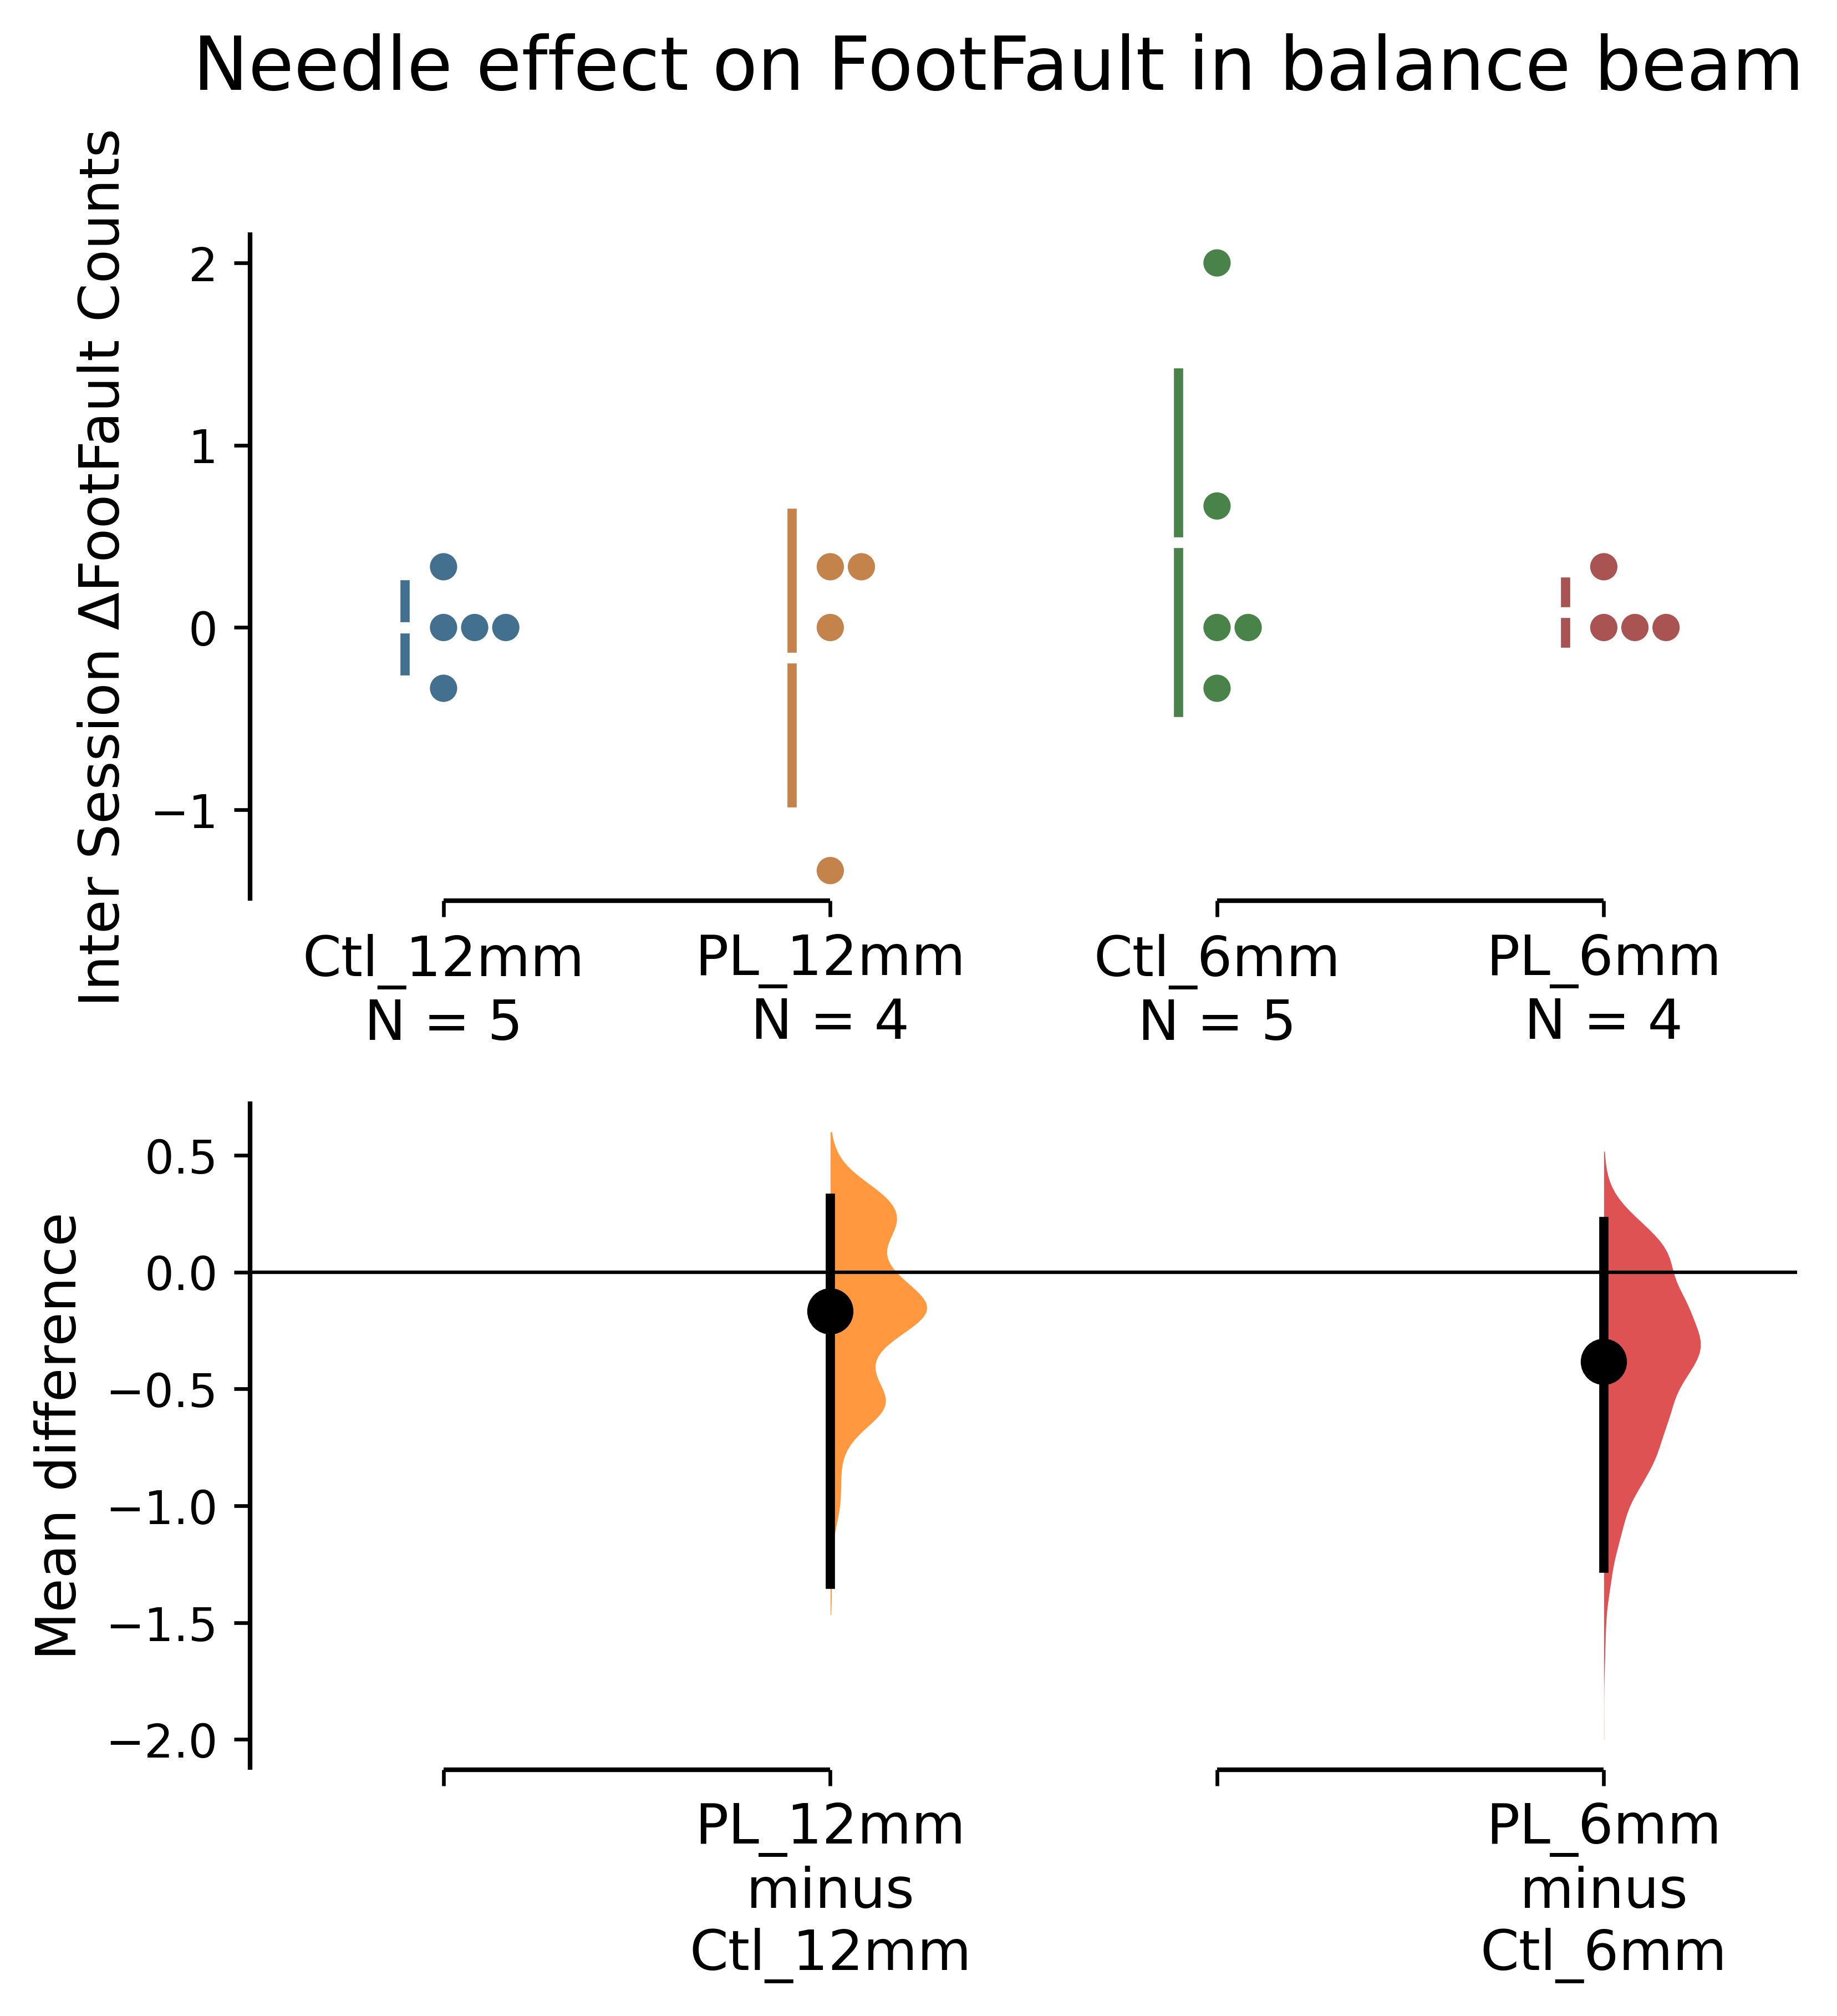

In [17]:
#[plot]Needle effect on FootFault in balance beam
plot = dabest_data.mean_diff.plot(swarm_label="Inter Session ΔFootFault Counts", 
                                  title="Needle effect on FootFault in balance beam", 
                                  float_contrast=False, dpi=600)

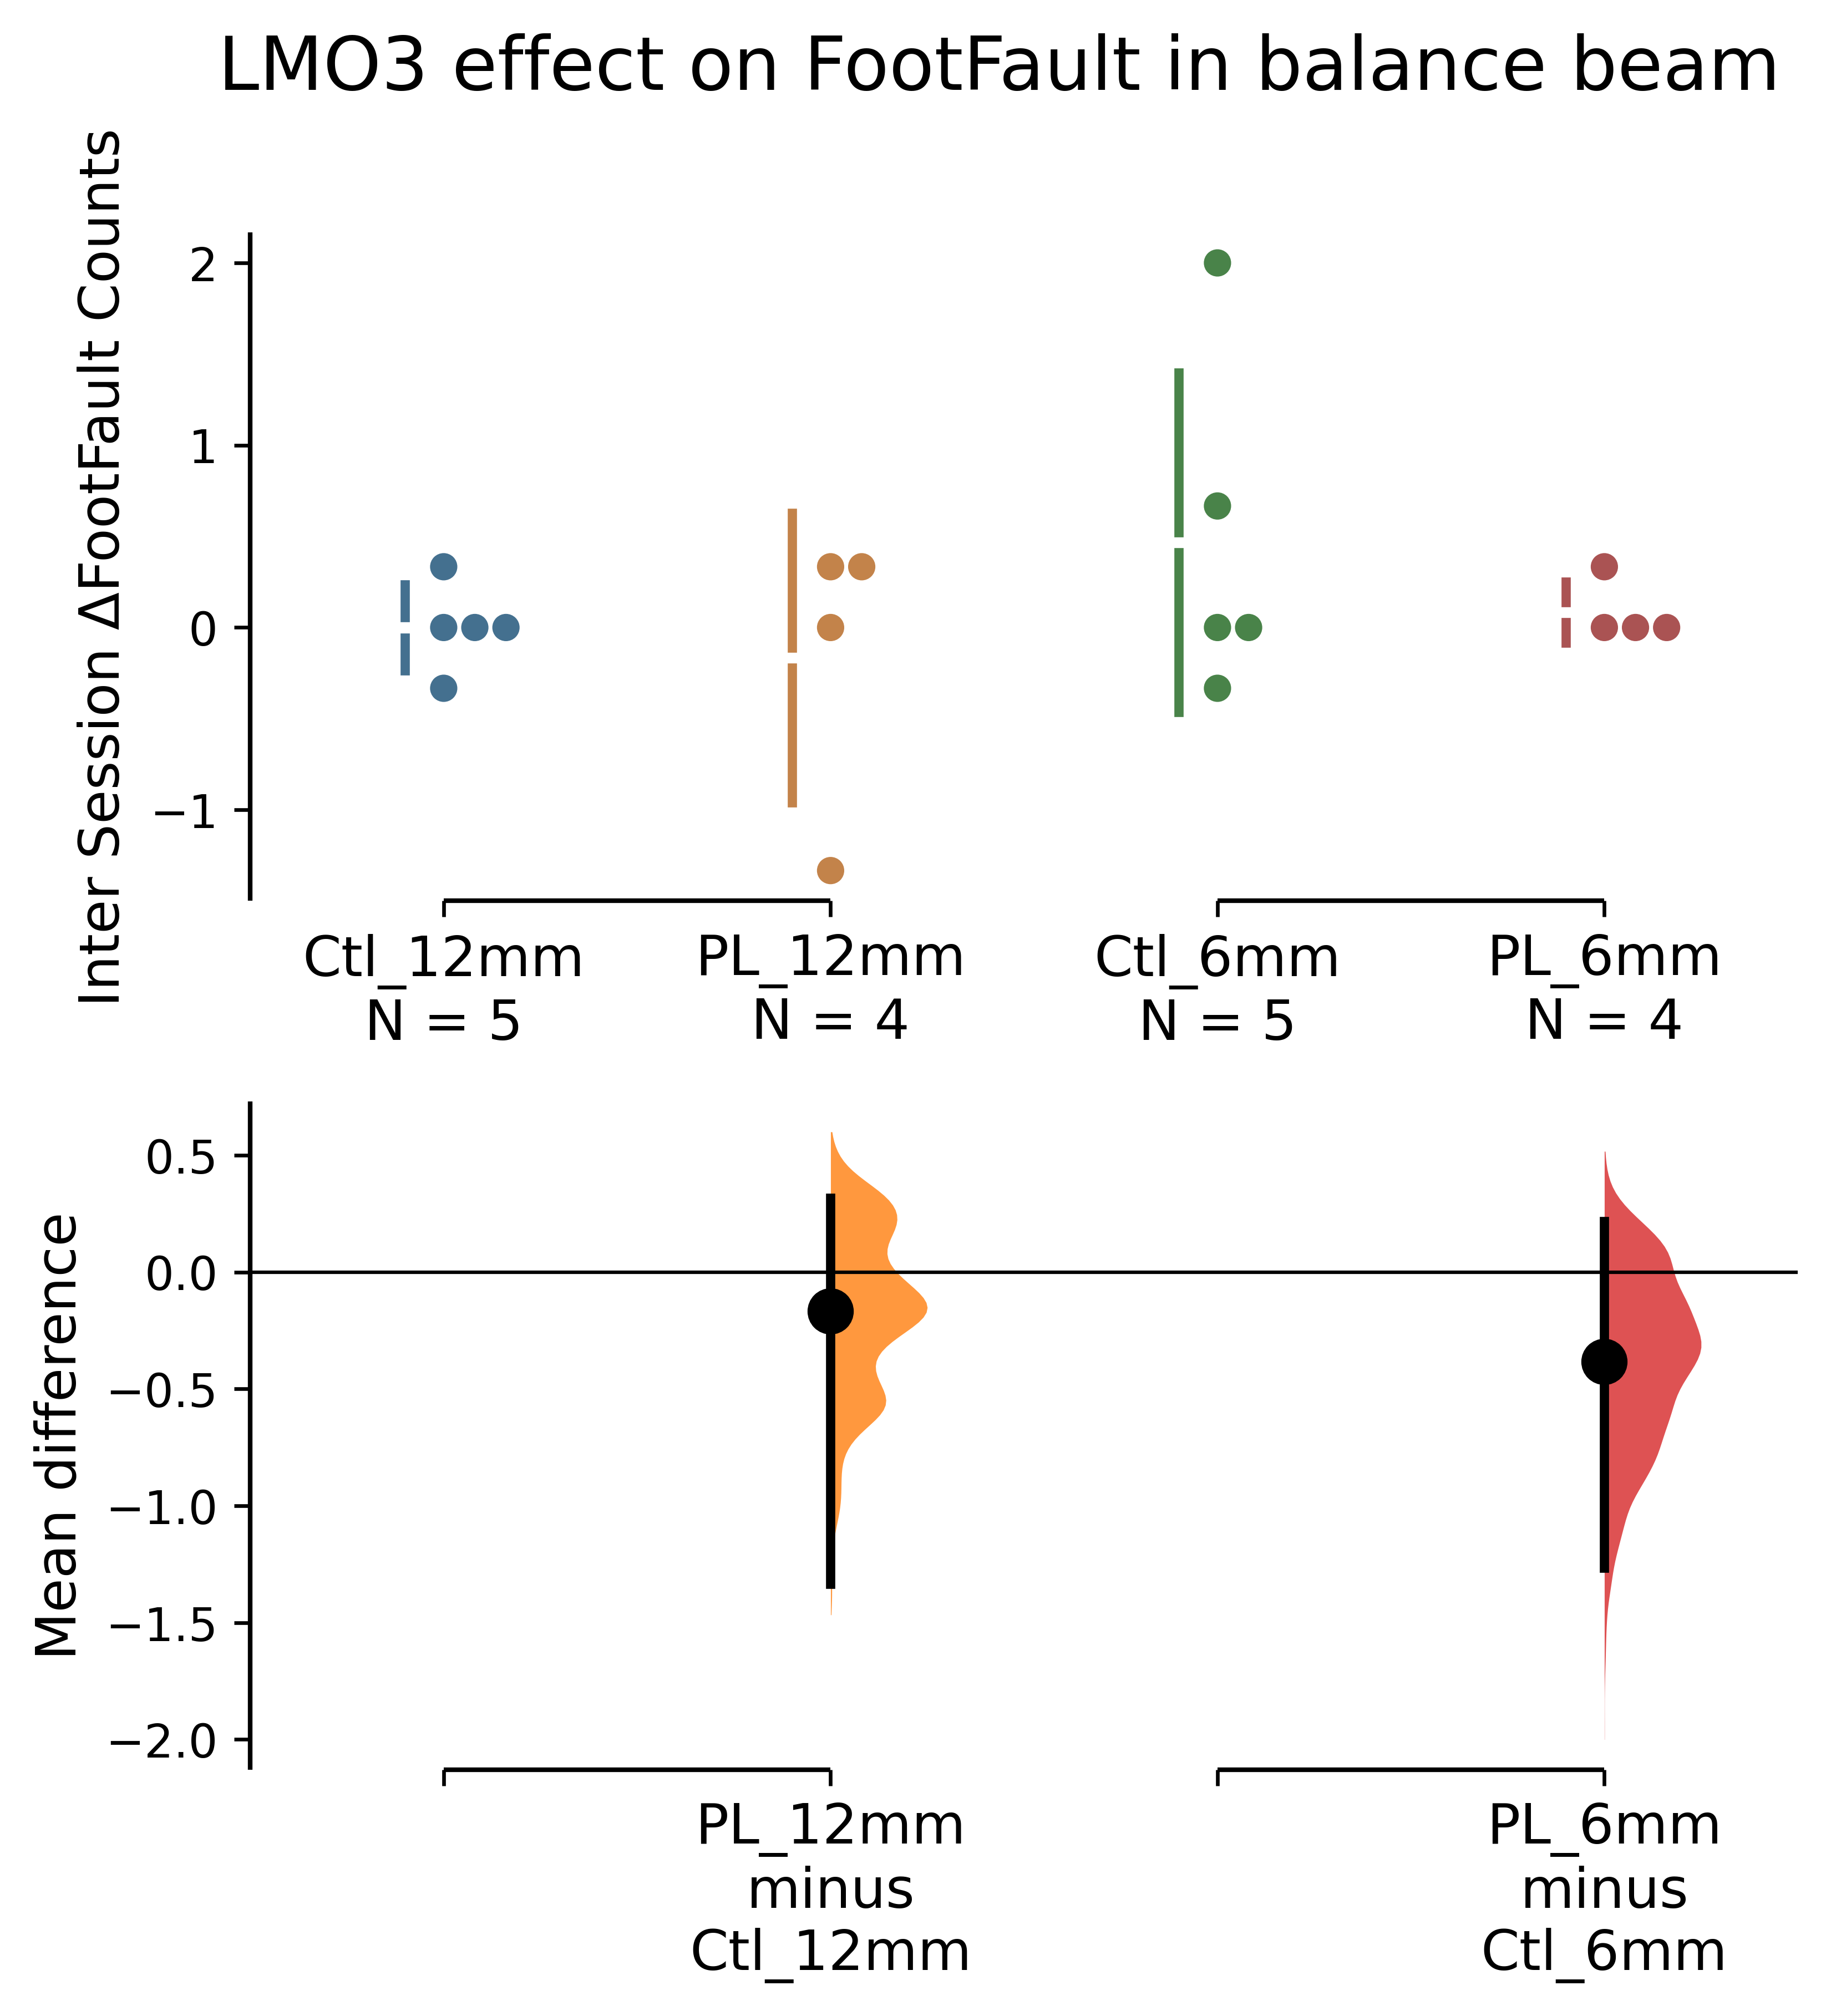

In [18]:
#[plot]LMO3 effect on FootFault in balance beam
plot = dabest_data.mean_diff.plot(swarm_label="Inter Session ΔFootFault Counts", 
                                  title="LMO3 effect on FootFault in balance beam", 
                                  float_contrast=False, dpi=600)

Travel Time----------------------------------------------------------------

In [38]:
# Reading video files (for travel time)

# Select the files
file_paths = select_files_get_paths("Select video files")

# Calculate the video durations
video_length_data = calculate_video_durations(file_paths)



In [41]:
# Transformation of vedio length data structure for statistics and visualization

length_data4dabest = convert_to_dabest_format(video_length_data)

In [ ]:
# statistics

# select session 
length_data4dabest_filtered = length_data4dabest[length_data4dabest['Session'] == 'D3-CTZ injection']

# Perform the statistical analysis
video_length_stats = dabest.load(data=length_data4dabest_filtered, x="Groups", y="Behavior_Counts", 
                          idx=(("ctl_12mm", "PL_12mm"),("ctl_6mm", "PL_6mm")), resamples=5000)

mean_diff = video_length_stats.mean_diff.statistical_tests
print(mean_diff)


    control     test  control_N  test_N      effect_size is_paired  \
0  ctl_12mm  PL_12mm          5       4  mean difference      None   
1   ctl_6mm   PL_6mm          5       4  mean difference      None   

   difference  ci    bca_low   bca_high  pvalue_permutation  pvalue_welch  \
0   -2.533333  95 -16.766667   7.366667              0.7790      0.721133   
1    4.050000  95 -10.550000  12.383333              0.4898      0.548040   

   statistic_welch  pvalue_students_t  statistic_students_t  \
0         0.372654           0.736266              0.350512   
1        -0.639838           0.528622             -0.662882   

   pvalue_mann_whitney  statistic_mann_whitney  
0             0.904762                    11.0  
1             0.555556                     7.0  


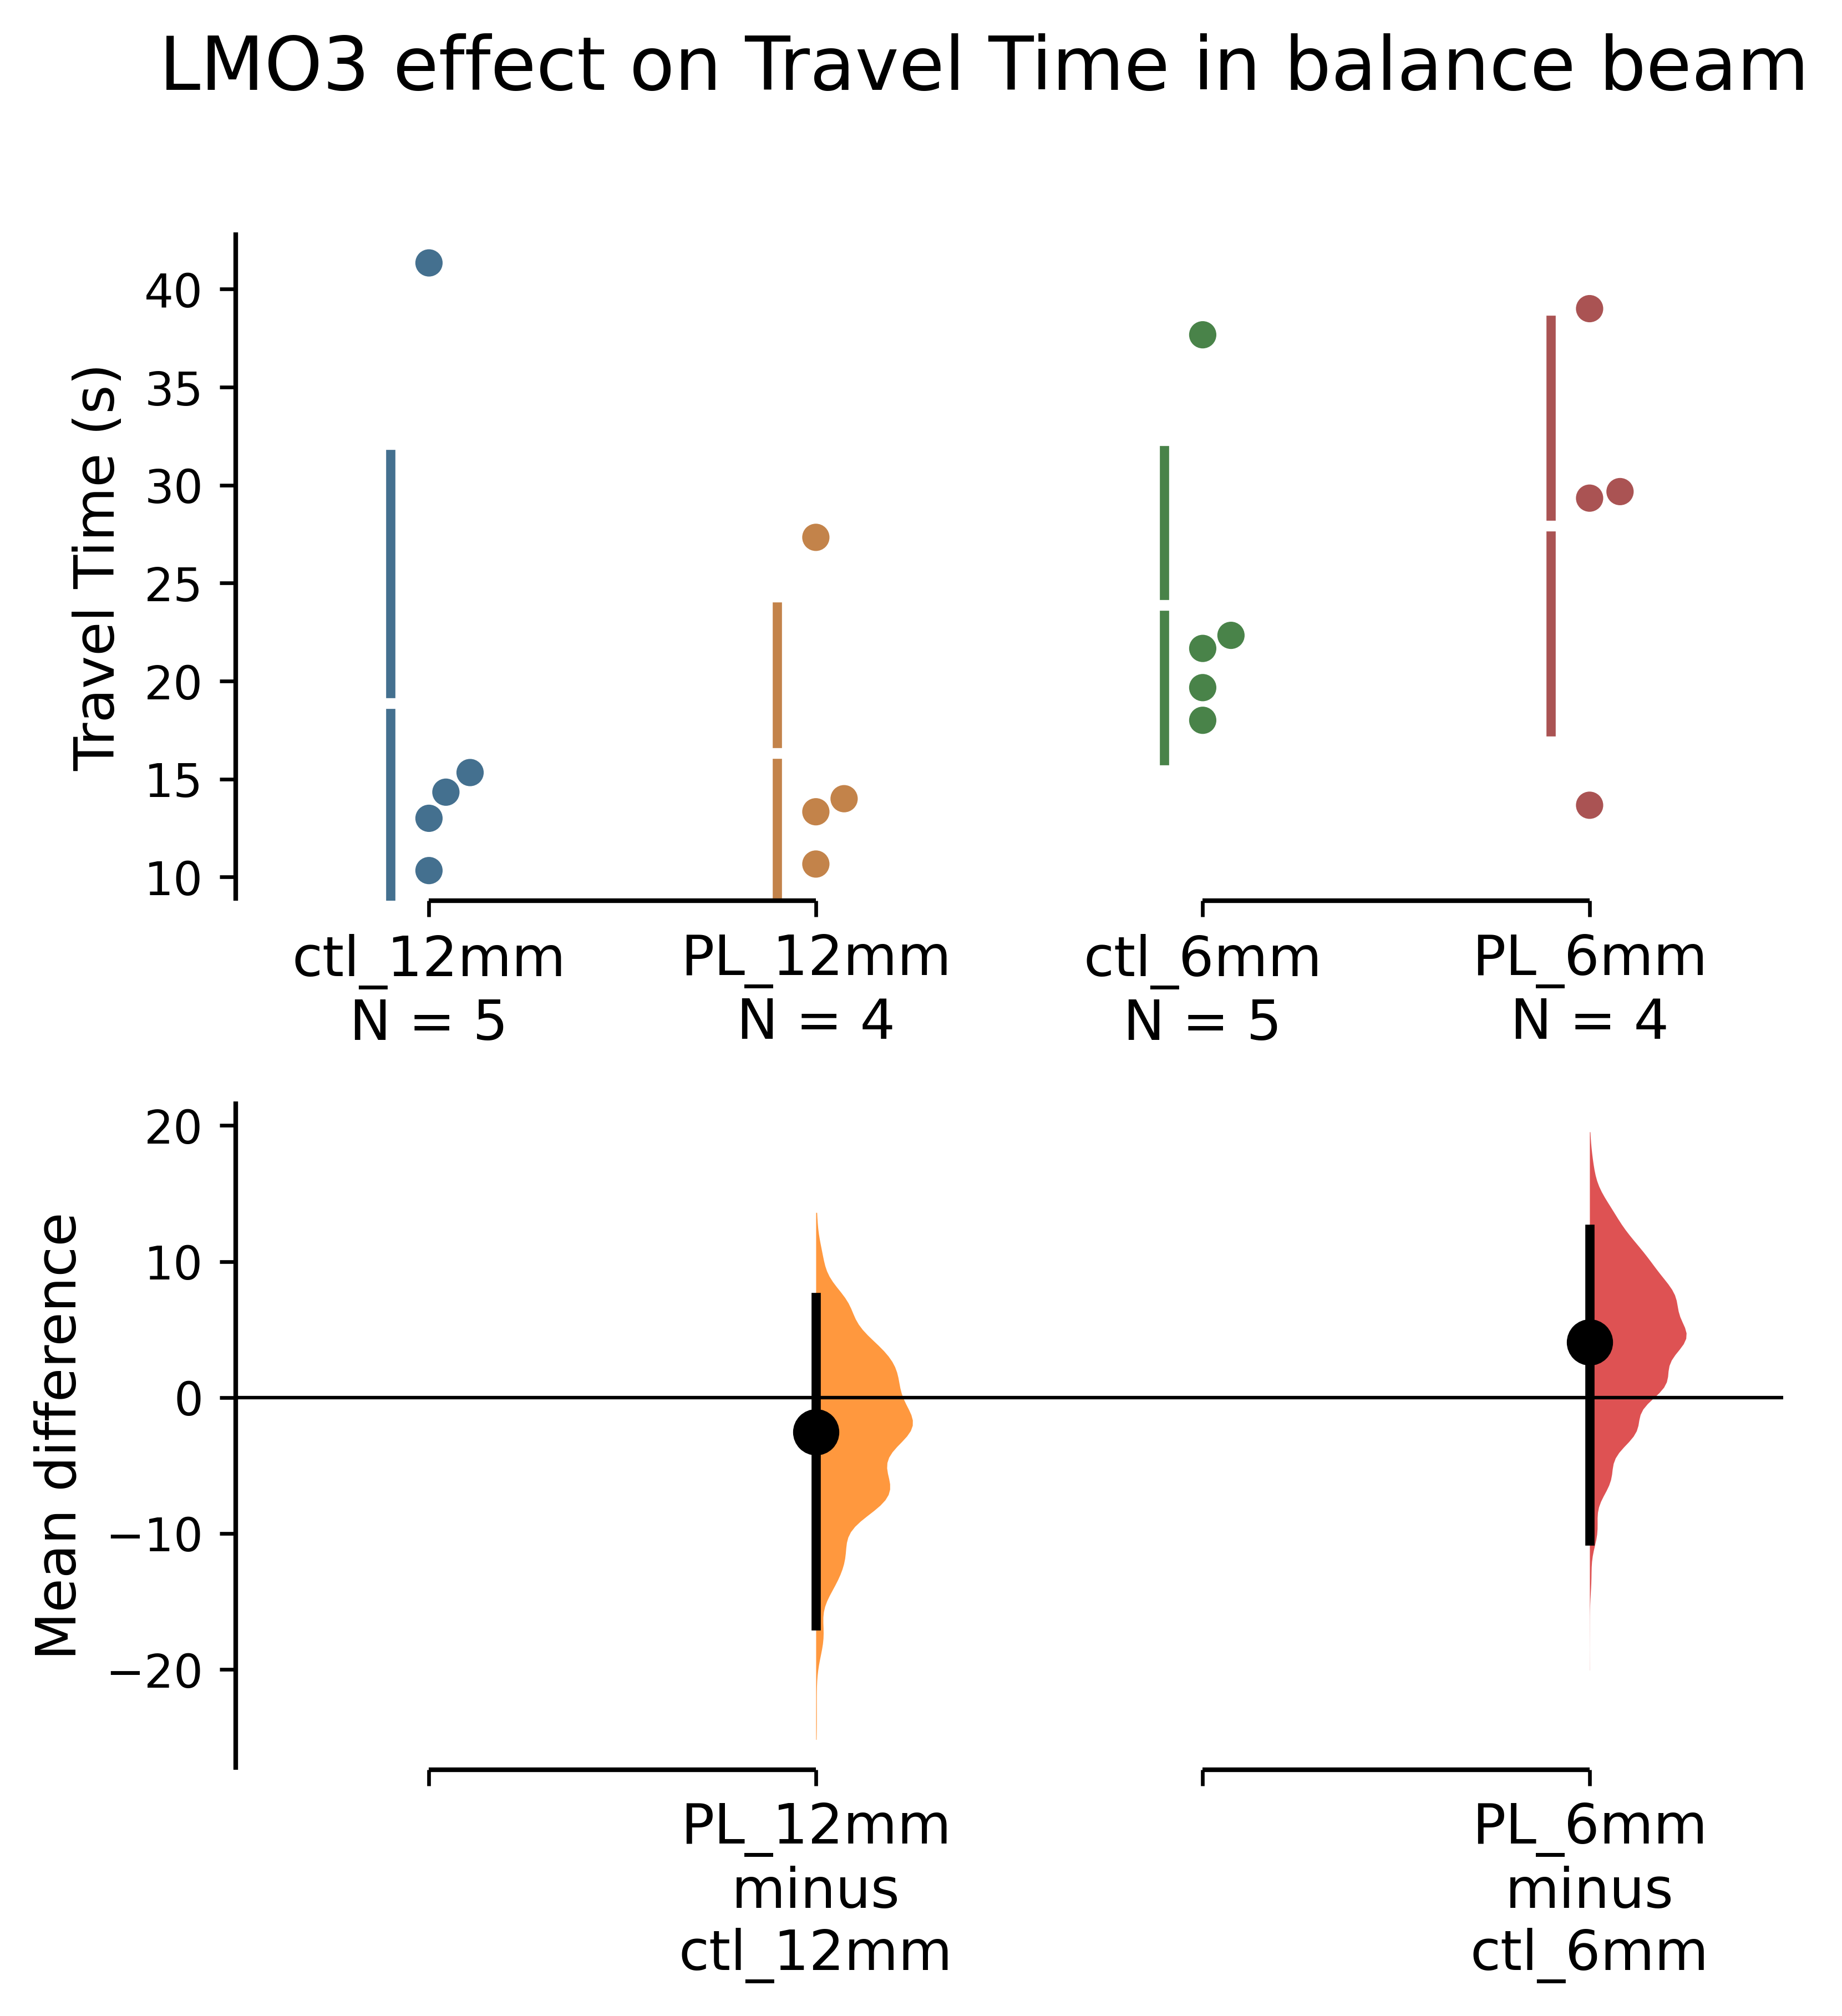

In [48]:
# Plot the results

plot = video_length_stats.mean_diff.plot(swarm_label="Travel Time (s)", 
                                  title="LMO3 effect on Travel Time in balance beam", 
                                  float_contrast=False, dpi=600)

old data (low dose)---------------

In [7]:
ctl_data = [0, -0.667, 0.333, 1.334, -0.333, -0.333, 1]
exp_data = [2.333333334, -0.333333333, 2, 0.333333333, 0, -0.333333333, 3.333333333]

DABEST v2024.03.29
                  
Good afternoon!
The current time is Mon Jan  6 16:58:43 2025.

The unpaired mean difference between CTZ-CTZ and CTZ-Saline is 0.857 [95%CI -0.238, 2.1].
The p-value of the two-sided permutation t-test is 0.212, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`
   control        test  control_N  test_N      effect_size is_paired  \
0  CTZ-CTZ  CTZ-Saline          7       7  mean difference      None   

   difference  ci   bca_low  bca_high  pvalue_permutation  pvalue_welch  \
0    0.857048  95 -0.238238  2.095143              0.2124      0.205436   

   statistic_we

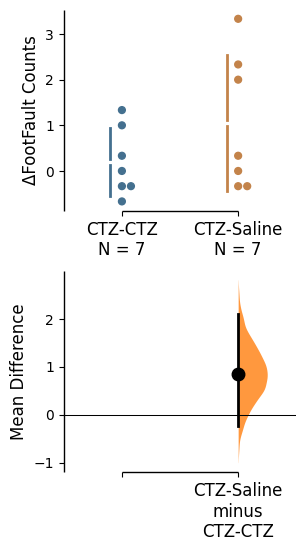

In [8]:
#statistical analysis and plot

import pandas as pd
import dabest

# 資料整理：長格式
data = {
    'Groups': ['CTZ-CTZ'] * len(ctl_data) + ['CTZ-Saline'] * len(exp_data),
    'Value': ctl_data + exp_data
}
df = pd.DataFrame(data)

# 使用 dabest 進行分析
dabest_data = dabest.load(
    data=df,
    idx=("CTZ-CTZ", "CTZ-Saline"),  # 明確指定組別順序
    x="Groups",
    y="Value"
)

# 獲取統計測試結果
mean_diff = dabest_data.mean_diff
mean_diff_stats = mean_diff.statistical_tests
print(mean_diff)  # 顯示統計結果
print(mean_diff_stats)  # 顯示統計測試結果





# 繪製圖表
plot = mean_diff.plot(
    swarm_label="ΔFootFault Counts",
    contrast_label="Mean Difference",
    float_contrast=False
)
